### Import required packages

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import os
import re
from pyvis.network import Network
import community.community_louvain as cl
import matplotlib.pyplot as plt

In [2]:
#Establish working directory
work_dir = 'c:/users/myxna/desktop/datascienceprojects/lotr'

In [3]:
#Download the spacy small english language model
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB 1.3 MB/s eta 0:00:10
     ---------------------------------------- 0.1/12.8 MB 2.1 MB/s eta 0:00:06
     - -------------------------------------- 0.3/12.8 MB 2.6 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 3.2 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.8 MB 3.7 MB/s eta 0:00:04
     --- ------------------------------------ 1.0/12.8 MB 3.7 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/12.8 MB 3.8 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 3.7 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 3.8 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 3.8 MB/s eta 0:00:03
     ------ --------------------------------- 2.0/12.8 MB 4.0 MB/s eta 0:00:03
     ------ --------------------------------- 2.1/12.8 MB 4

In [4]:
#Load spacy's english language model
NER = spacy.load('en_core_web_sm')

### Extract text from books

In [5]:
#Load Tolkien's book file names in list
books = [b for b in os.scandir(work_dir + '/data') if '.txt' in b.name]

In [6]:
#View contents of book name list
books

[<DirEntry '00 - The Silmarillion.txt'>,
 <DirEntry '01 - The Hobbit.txt'>,
 <DirEntry '02 - The Lord of the Rings.txt'>]

In [7]:
#Open and read books to variable
book = books[2]
with open(book, 'r', encoding='ansi', errors='ignore') as file:
    book_text = file.read()

#Increase the max_length limit of spacy's NER model
NER.max_length = 3000000  # or any value greater than the length of your text

#Process the text with model
book_doc = NER(book_text)

In [8]:
#Display entities in the first 2500 tokens of the text
displacy.render(book_doc[0:2500], style = 'ent')

In [9]:
#Load character data from pickle file to pandas df
character_df = pd.read_pickle(work_dir + '/data/characters.pkl')

In [10]:
#Show first 50 entries of character_df
character_df.head(50)

,book,character
0,Category:The Hobbit characters,Bilbo Baggins
1,Category:The Hobbit characters,Balin
2,Category:The Hobbit characters,Bard
3,Category:The Hobbit characters,Beorn
4,Category:The Hobbit characters,Bifur
5,Category:The Hobbit characters,Bladorthin
6,Category:The Hobbit characters,Bofur
7,Category:The Hobbit characters,Bolg
8,Category:The Hobbit characters,Bombur
9,Category:The Hobbit characters,Captain of the guard


### Clean and tidy character names for NER

In [11]:
#Function to split rows with multiple characters in the same row
def split_rows(df):
    new_rows = []
    for index, row in df.iterrows():
        names = row['character'].replace(' and ', ',').split(',')
        for name in names:
            new_row = row.copy()
            new_row['character'] = name.strip()
            new_rows.append(new_row)
    return pd.DataFrame(new_rows)

In [12]:
#Separate rows with multiple names in character_df
character_df = split_rows(character_df)

#Display the new character_df's 50 first rows
character_df.head(50)

,book,character
0,Category:The Hobbit characters,Bilbo Baggins
1,Category:The Hobbit characters,Balin
2,Category:The Hobbit characters,Bard
3,Category:The Hobbit characters,Beorn
4,Category:The Hobbit characters,Bifur
5,Category:The Hobbit characters,Bladorthin
6,Category:The Hobbit characters,Bofur
7,Category:The Hobbit characters,Bolg
8,Category:The Hobbit characters,Bombur
9,Category:The Hobbit characters,Captain of the guard


In [13]:
#Remove special characters from character names
character_df['character'] = character_df['character'].apply(lambda x: re.sub('[\(}.*?{\)]', '', x))

In [14]:
#Create a column in the character_df containing the character's first name
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [15]:
#Look through the dataframe for quality
pd.set_option('display.max_rows', None)
character_df

,book,character,character_firstname
0,Category:The Hobbit characters,Bilbo Baggins,Bilbo
1,Category:The Hobbit characters,Balin,Balin
2,Category:The Hobbit characters,Bard,Bard
3,Category:The Hobbit characters,Beorn,Beorn
4,Category:The Hobbit characters,Bifur,Bifur
5,Category:The Hobbit characters,Bladorthin,Bladorthin
6,Category:The Hobbit characters,Bofur,Bofur
7,Category:The Hobbit characters,Bolg,Bolg
8,Category:The Hobbit characters,Bombur,Bombur
9,Category:The Hobbit characters,Captain of the guard,Captain


In [16]:
#Define a dictionary to map first names to nicknames
nickname_mapping = {
    'Samwise': 'Sam',
    'Meriadoc': 'Merry',
    'Perigrin': 'Pippin',
    'Gandalf': 'Mithrandir',
    'Gollum': 'Sméagol',
    'Aragorn': 'Strider',
    'Sauron': 'Dark Lord'
}

#Create an empty list to store nicknames
nicknames = []

#Iterate over the 'character_firstname' column
for first_name in character_df['character_firstname']:
    #Check if the first name is in the nickname mapping dictionary
    if first_name in nickname_mapping:
        #If it is, append the corresponding nickname
        nicknames.append(nickname_mapping[first_name])
    else:
        #If not, append an empty string
        nicknames.append('')

#Add the list of nicknames as a new column to the DataFrame
character_df['character_nickname'] = nicknames

### Extract, clean, and tidy entities from book text

In [17]:
#Create a list to be used to hold sentences and entities contained within respective sentences
sent_entity_df= []

#Loop over sentences in books
for sent in book_doc.sents:
    #Store entities from individual sentence in list
    entity_list = [ent.text for ent in sent.ents]
    #Add sentence and entities to dataframe
    sent_entity_df.append({'sentence': sent, 'entities': entity_list})
    
#Convert list of dictionaries to dataframe    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [18]:
#Look at the first 100 sentences saved and their respective entities
sent_entity_df.head(100)

,sentence,entities
0,"(Three, Rings, for, the, Elven, -, kings, unde...","[Three, Elven, Seven, Dwarf, Nine, Mortal Men,..."
1,"(One, Ring, to, rule, them, all, ,, One, Ring,...","[One, One, Shadows]"
2,"(FOREWORD, \n\n, This, tale, grew, in, the, te...","[FOREWORD, the Great War of the Ring]"
3,"(It, was, begun, soon, after, _)",[]
4,"(The, Hobbit, _, was, written, and, before, it...","[The Hobbit, 1937, first, the Elder Days, some..."
5,"(I, desired, to, do, this, for, my, own, satis...",[Elvish]
6,"(When, those, whose, advice, and, opinion, I, ...",[]
7,"(no, hope, ,, _)",[]
8,"(I, went, back, to, the, sequel, ,, encouraged...",[]
9,"(But, the, story, was, drawn, irresistibly, to...",[]


In [19]:
#Function to filter the sentence-entity dataframe for sentences that only contain 
#character full names, first names, or nicknames
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character)
            or ent in list(character_df.character_firstname)
            or ent in list(character_df.character_nickname)
           ]

In [20]:
#Create a new column for the sentence-entity dataframe that captures only the 
#specified character names from the entitiy list
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

#Create a new DataFrame that contains only sentences where at least one recognized entity is a
#specified character
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]

#Look at the first 10 instances of the new, filtered sentence-entity DataFrame
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
11,"(The, Hobbit, ,, _, in, which, there, were, al...","[The Hobbit, Gondolin, Durin]",[Durin]
16,"(In, spite, of, the, darkness, of, the, next, ...","[the next five years, night, Balin, Moria]",[Balin]
42,"(If, it, had, inspired, or, directed, the, dev...","[Sauron, Barad-dûr]",[Sauron]
55,"(It, is, an, essential, part, of, the, plot, ,...",[Saruman],[Saruman]
71,"(That, story, was, derived, from, the, earlier...","[the Red Book, Bilbo, Hobbit]",[Bilbo]
99,"(But, in, the, days, of, Bilbo, ,, and, of, Fr...","[the days, Bilbo]",[Bilbo]
101,"(Of, their, original, home, the, Hobbits, in, ...",[Bilbo],[Bilbo]
122,"(Even, in, Bilbo, 's, time, the, strong, Fallo...",[Bilbo],[Bilbo]
126,"(Most, of, their, earlier, settlements, had, l...","[Bilbo, one, first, Bree, Chetwood, some forty...",[Bilbo]
147,"(In, olden, days, they, had, ,, of, course, ,,...","[olden days, Bilbo]",[Bilbo]


In [21]:
#Split rows of the sentence-entity DataFrame where multiple characters are
#present in the same sentence
sent_entity_df_filtered ['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
                                                                                                               for item in x])

C:\Users\myxna\AppData\Local\Temp\ipykernel_33308\2354310285.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered ['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [22]:
#Display the sentence-entity DataFrame
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
11,"(The, Hobbit, ,, _, in, which, there, were, al...","[The Hobbit, Gondolin, Durin]",[Durin]
16,"(In, spite, of, the, darkness, of, the, next, ...","[the next five years, night, Balin, Moria]",[Balin]
42,"(If, it, had, inspired, or, directed, the, dev...","[Sauron, Barad-dûr]",[Sauron]
55,"(It, is, an, essential, part, of, the, plot, ,...",[Saruman],[Saruman]
71,"(That, story, was, derived, from, the, earlier...","[the Red Book, Bilbo, Hobbit]",[Bilbo]
...,...,...,...
35939,"(And, the, ship, went, out, into, the, High, S...","[the High Sea, West, last on a night, Frodo]",[Frodo]
35941,"(But, to, Sam, the, evening, deepened, to, dar...","[Sam, evening, Haven, the grey sea, West]",[Sam]
35943,"(Beside, him, stood, Merry, and, Pippin, ,, an...","[Merry, Pippin]",[Merry]
35946,"(At, last, they, rode, over, the, downs, and, ...","[the East Road, Merry, Pippin, Buckland]",[Merry]


### Extract relationships between characters from text using NER

In [23]:
#Set window size to define what a relationship is
window_size = 5
#Create a list to house relationships between characters that will become a DataFrame
relationships = []

#Loop through the sentence-entity DataFrame
for i in range(sent_entity_df_filtered.index[-1]):
    #Set end of window, ensure the window does not exceed dataframe index
    end_i = min(i + window_size, sent_entity_df_filtered.index[-1])
    #Create list of characters that fall in the window size
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    #Create a new list of only unique characters from char_list
    char_unique = [char_list[i] for i in range(len(char_list))
                  if (i == 0) or char_list[i] != char_list[i-1]]
    #Loop through char_unique to add unique relationships to relationship dataframe.
    #Ensures character does not have a relationship with themselves
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({'source': a, 'target': b})

In [24]:
#Store list of dictionaries as DataFrame
relationship_df = pd.DataFrame(relationships)

In [25]:
#Show first 150 relationships in relationship DataFrame
relationship_df.head(150)

,source,target
0,Durin,Balin
1,Bilbo,Bandobras
2,Bilbo,Bandobras
3,Bilbo,Bandobras
4,Bilbo,Bandobras
...,...,...
145,Elendil,Sauron
146,Sauron,Meriadoc
147,Sauron,Meriadoc
148,Meriadoc,Elrond


In [26]:
#Alphabetically sort the relationships 
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Balin,Durin
1,Bandobras,Bilbo
2,Bandobras,Bilbo
3,Bandobras,Bilbo
4,Bandobras,Bilbo
...,...,...
20287,Merry,Sam
20288,Merry,Sam
20289,Merry,Sam
20290,Merry,Sam


In [27]:
#Create a new column called 'value' to count each relationship as 1 instance.
relationship_df['value'] = 1
#Group duplicate relationships and sum the values to quantify the strength of the relationship
relationship_df = relationship_df.groupby(['source', 'target'], sort = False, as_index = False).sum()

In [28]:
#Invert the nickname mapping dictionary
inverse_mapping = {v: k for k, v in nickname_mapping.items()}

#Replace values in 'source' and 'target' columns with dictionary keys
relationship_df['source'] = relationship_df['source'].map(inverse_mapping).fillna(relationship_df['source'])
relationship_df['target'] = relationship_df['target'].map(inverse_mapping).fillna(relationship_df['target'])

In [29]:
#Look at the first 10 rows of relationship Dataframe
relationship_df.head(50)

,source,target,value
0,Balin,Durin,5
1,Bandobras,Bilbo,5
2,Bilbo,Frodo,678
3,Bilbo,Thorin,23
4,Bilbo,Gollum,168
5,Gandalf,Gollum,34
6,Bilbo,Gandalf,272
7,Bilbo,Peregrin,2
8,Barahir,Frodo,3
9,Frodo,Meriadoc,3


### Visualize the network

In [30]:
#Build the network
G = nx.from_pandas_edgelist(relationship_df,
                           source = 'source',
                           target = 'target',
                           edge_attr = 'value',
                           create_using = nx.Graph())

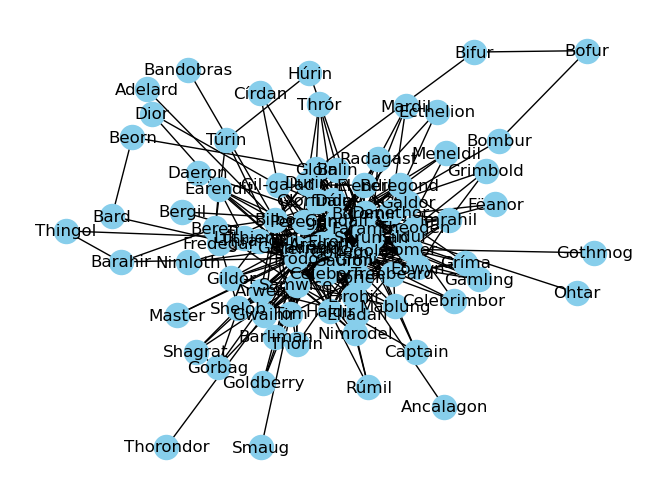

In [31]:
#Set visualization parameters for basic network
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels = True, node_color = 'skyblue', edge_cmap = plt.cm.Blues)
#Save figure
plt.savefig(work_dir + '/assets/img/LOTR_basic_net.png')
#Show figure
plt.show()

In [32]:
#Show each character's number of degrees
dict(G.degree)

{'Balin': 11,
 'Durin': 9,
 'Bandobras': 1,
 'Bilbo': 26,
 'Frodo': 50,
 'Thorin': 4,
 'Gollum': 23,
 'Gandalf': 50,
 'Peregrin': 12,
 'Barahir': 3,
 'Meriadoc': 35,
 'Elendil': 12,
 'Sauron': 32,
 'Elrond': 39,
 'Celeborn': 15,
 'Galadriel': 18,
 'Samwise': 38,
 'Adelard': 1,
 'Fredegar': 5,
 'Saruman': 28,
 'Gil-galad': 10,
 'Isildur': 19,
 'Ancalagon': 1,
 'Gildor': 6,
 'Tom': 10,
 'Goldberry': 3,
 'Master': 2,
 'Barliman': 5,
 'Aragorn': 38,
 'Beren': 9,
 'Lúthien': 10,
 'Thingol': 2,
 'Eärendil': 7,
 'Glorfindel': 8,
 'Arwen': 5,
 'Lórien': 22,
 'Elladan': 8,
 'Elrohir': 9,
 'Glóin': 16,
 'Beorn': 2,
 'Bard': 2,
 'Dáin': 9,
 'Bifur': 2,
 'Bofur': 2,
 'Bombur': 2,
 'Gimli': 28,
 'Galdor': 9,
 'Legolas': 31,
 'Thranduil': 5,
 'Boromir': 28,
 'Thrór': 4,
 'Celebrimbor': 3,
 'Dior': 2,
 'Círdan': 2,
 'Ohtar': 1,
 'Meneldil': 3,
 'Denethor': 21,
 'Radagast': 4,
 'Gwaihir': 8,
 'Húrin': 2,
 'Túrin': 3,
 'Daeron': 2,
 'Nimrodel': 8,
 'Haldir': 12,
 'Rúmil': 3,
 'Éomer': 24,
 'Théoden': 1

In [33]:
#Function to update node labels
def update_node_labels(graph, character_dataframe):
    #Loop through nodes in graph
    for node in graph.nodes:
        first_name = node
        full_name = character_dataframe.loc[character_dataframe['character_firstname'] == 
                                            first_name, 'character'].iloc[0]
        graph.nodes[node]['label'] = full_name

In [34]:
def build_adv_network(graph, character_dataframe):

    #Set paramaters for advanced network visualiztion
    net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white')

    #Store the degree for each node in a dictionary 
    node_degree = dict(graph.degree)

    #Set size of nodes based on the node_degree
    nx.set_node_attributes(graph, node_degree, 'size')

    #Update node labels
    update_node_labels(graph, character_dataframe)

    #Rebuild network
    net.from_nx(G)

    #Set additional options for the network
    net.set_options('''
    var options = {
    "physics": {
    "maxVelocity": 5
    }
    }
    ''')
    return net

In [35]:
#Build advanced network
adv_net = build_adv_network(G, character_df)

#Save figure
adv_net.write_html(work_dir + '/assets/img/LOTR_adv_net.html')

#Display advanced network
adv_net.show('LOTR_adv_net.html')

LOTR_adv_net.html


In [36]:
#Use the louvain community algorithm to determine the optimal community partitions
communities = cl.best_partition(G)

In [37]:
#Display character's communities
communities

{'Balin': 0,
 'Durin': 0,
 'Bandobras': 3,
 'Bilbo': 3,
 'Frodo': 2,
 'Thorin': 2,
 'Gollum': 4,
 'Gandalf': 1,
 'Peregrin': 1,
 'Barahir': 3,
 'Meriadoc': 1,
 'Elendil': 4,
 'Sauron': 4,
 'Elrond': 3,
 'Celeborn': 0,
 'Galadriel': 0,
 'Samwise': 2,
 'Adelard': 3,
 'Fredegar': 1,
 'Saruman': 4,
 'Gil-galad': 4,
 'Isildur': 4,
 'Ancalagon': 4,
 'Gildor': 1,
 'Tom': 1,
 'Goldberry': 2,
 'Master': 2,
 'Barliman': 1,
 'Aragorn': 4,
 'Beren': 3,
 'Lúthien': 3,
 'Thingol': 3,
 'Eärendil': 3,
 'Glorfindel': 4,
 'Arwen': 3,
 'Lórien': 0,
 'Elladan': 3,
 'Elrohir': 3,
 'Glóin': 0,
 'Beorn': 2,
 'Bard': 2,
 'Dáin': 0,
 'Bifur': 2,
 'Bofur': 2,
 'Bombur': 2,
 'Gimli': 0,
 'Galdor': 4,
 'Legolas': 0,
 'Thranduil': 0,
 'Boromir': 4,
 'Thrór': 0,
 'Celebrimbor': 4,
 'Dior': 3,
 'Círdan': 1,
 'Ohtar': 4,
 'Meneldil': 4,
 'Denethor': 4,
 'Radagast': 4,
 'Gwaihir': 4,
 'Húrin': 2,
 'Túrin': 2,
 'Daeron': 2,
 'Nimrodel': 0,
 'Haldir': 0,
 'Rúmil': 0,
 'Éomer': 1,
 'Théoden': 1,
 'Treebeard': 1,
 'Gríma'

In [38]:
def build_adv_comm_net(G, communities):
    nx.set_node_attributes(G, communities, 'group')
    
    comm_net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white')
    comm_net.set_options('''
    var options = {
    "physics": {
    "maxVelocity": 5
    }
    }
    ''')

    #Update node labels
    update_node_labels(G, character_df)
    
    comm_net.from_nx(G)
    
    return comm_net

In [41]:
#Build advanced network with nodes that have a community designation
comm_adv_net = build_adv_comm_net(G, communities)


comm_adv_net.write_html(work_dir + '/assets/img/LOTR_comm_adv_net.html')

#Display communities in the advanced network
comm_adv_net.show('LOTR_comm_adv_net.html')



LOTR_comm_adv_net.html
